In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../Dữ liệu Lịch sử GVR.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [5]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [6]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [7]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1269,2018-03-22,10736,10834,11130,10046,260.80K,0.00%
1268,2018-03-23,10342,10440,10440,9849,111.80K,-3.67%
1267,2018-03-26,10145,10046,10342,10046,267.80K,-1.90%
1266,2018-03-27,10736,10637,10834,10342,52.20K,5.83%
1265,2018-03-28,11327,10736,11622,10637,139.80K,5.50%
...,...,...,...,...,...,...,...
4,2023-04-24,15300,15150,15300,14950,758.10K,1.32%
3,2023-04-25,15100,15350,15500,15050,1.30M,-1.31%
2,2023-04-26,15350,15100,15350,15000,1.12M,1.66%
1,2023-04-27,15450,15450,15800,15350,2.55M,0.65%


In [8]:
tranformData(df)

In [9]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [10]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-04-24,15300.0,15150.0,15300.0,14950.0,758100.0,0.0132
2023-04-25,15100.0,15350.0,15500.0,15050.0,1300000.0,-0.0131
2023-04-26,15350.0,15100.0,15350.0,15000.0,1120000.0,0.0166


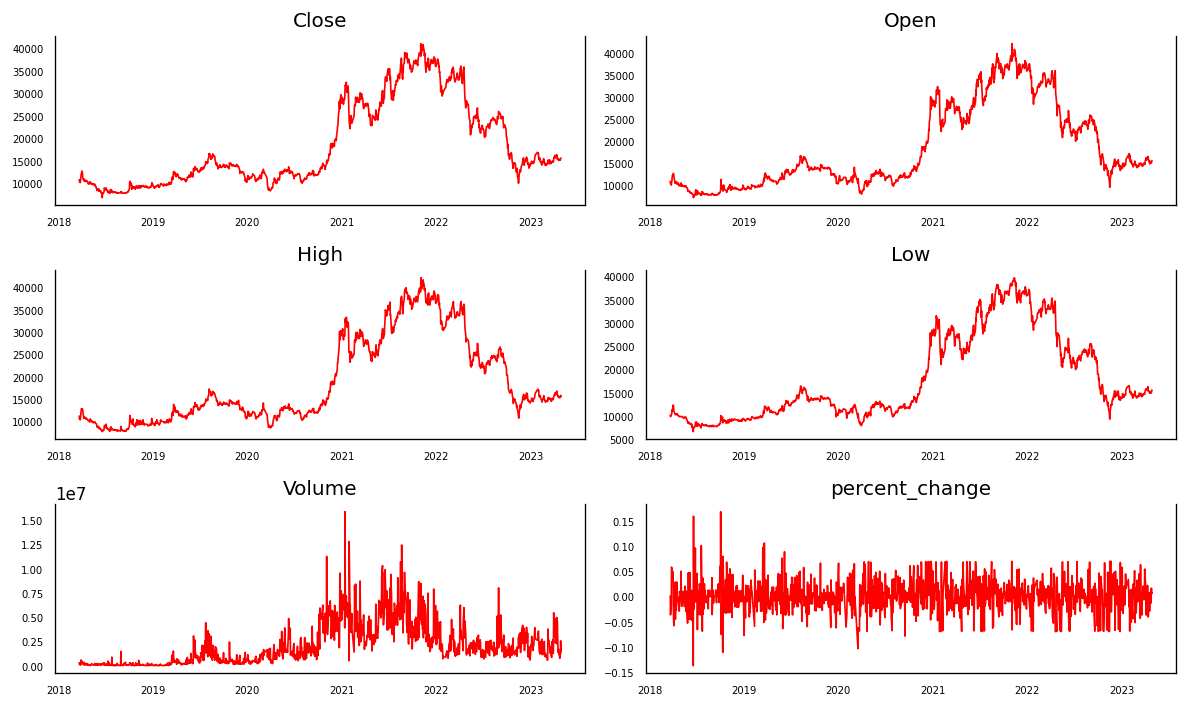

In [11]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [12]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.000,0.0002,0.0001,0.0047,0.0000,0.0021
Open_y,0.000,1.0000,0.0000,0.0000,0.0000,0.0000
High_y,0.000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.000,0.0000,0.0000,0.0000,1.0000,0.0004
percent_change_y,0.094,0.1694,0.1625,0.1002,0.1667,1.0000


In [13]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  774.46    > 83.9383   =>   True
Open   ::  528.97    > 60.0627   =>   True
High   ::  321.82    > 40.1749   =>   True
Low    ::  127.23    > 24.2761   =>   True
Volume ::  38.12     > 12.3212   =>   True
percent_change ::  0.31      > 4.1296    =>   False


In [14]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(762, 6)
(254, 6)
(254, 6)


In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [16]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2067
 No. Lags Chosen       = 11
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9377. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.015
 No. Lags Chosen       = 11
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9573. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [17]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [18]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4067
 No. Lags Chosen       = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7054
 No. Lags Chosen       = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [19]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [20]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3632
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2396
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [21]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  69.16987020310826
BIC :  69.42618650699576
FPE :  1.096716319553139e+30
HQIC:  69.26857924343793 

Lag Order = 2
AIC :  67.49000703270033
BIC :  67.9665153494287
FPE :  2.0443083510365884e+29
HQIC:  67.67352474812036 

Lag Order = 3
AIC :  66.53113806317369
BIC :  67.2282944844311
FPE :  7.83670706781481e+28
HQIC:  66.7996506089315 

Lag Order = 4
AIC :  65.87786444211972
BIC :  66.79612661993312
FPE :  4.078081193169337e+28
HQIC:  66.2315586255241 

Lag Order = 5
AIC :  65.50766054090761
BIC :  66.64748769502724
FPE :  2.8166693505181176e+28
HQIC:  65.94672382445087 

Lag Order = 6
AIC :  65.17841187919845
BIC :  66.54026480452704
FPE :  2.0268900472683702e+28
HQIC:  65.70303238369756 

Lag Order = 7
AIC :  64.97197511691137
BIC :  66.55631619097827
FPE :  1.6492800243219015e+28
HQIC:  65.58234162466816 

Lag Order = 8
AIC :  64.77229208391688
BIC :  66.57958527439726
FPE :  1.3512349039753475e+28
HQIC:  65.46859404189749 

Lag Order = 9
AIC :  64.45714583437949
B

In [173]:
x = model.select_order(maxlags=100)
x.summary()

,AIC,BIC,FPE,HQIC
0,73.26,73.30,6.555e+31,73.28
1,69.31,69.60,1.268e+30,69.43
2,67.66,68.19,2.417e+29,67.86
3,66.69,67.47,9.208e+28,66.99
4,66.09,67.11,5.045e+28,66.49
5,65.75,67.01,3.576e+28,66.24
6,65.42,66.94*,2.592e+28,66.01
7,65.22,66.98,2.117e+28,65.90
8,65.00,67.00,1.699e+28,65.78
9,64.70,66.95,1.262e+28,65.57


In [274]:
model_fitted = model.fit(65)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     23:15:08
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    78.6456
Nobs:                     695.000    HQIC:                   69.2385
Log likelihood:          -25570.3    FPE:                7.58326e+27
AIC:                      63.3074    Det(Omega_mle):     5.20938e+26
--------------------------------------------------------------------
Results for equation Close
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      1.374313        15.107835            0.091           0.928
L1.Close                  -0.482690         0.200769           -2.404           0.016
L1.Open                   -0.135886     

In [275]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

65


array([[-3.41000e+02,  1.51000e+03, -1.02300e+03,  7.79000e+02,
        -1.61000e+06, -5.30000e-02],
       [ 9.70000e+01, -1.36300e+03, -4.80000e+01, -9.70000e+01,
        -3.00000e+05,  1.58000e-02],
       [ 1.55900e+03,  1.31400e+03,  2.04500e+03,  9.74000e+02,
         1.35200e+07,  5.03000e-02],
       [-1.21800e+03,  8.77000e+02,  4.90000e+01,  3.90000e+02,
        -2.04200e+07, -9.72000e-02],
       [-1.02200e+03, -1.94800e+03, -2.92300e+03, -2.33800e+03,
         6.53000e+06,  1.09000e-02],
       [ 1.11900e+03, -2.92000e+02,  2.14400e+03,  4.38000e+02,
         3.64000e+06,  6.83000e-02],
       [-2.43400e+03,  1.36300e+03, -1.46200e+03, -7.79000e+02,
        -2.99000e+06, -1.11300e-01],
       [ 8.76000e+02, -2.33700e+03, -1.65500e+03, -6.33000e+02,
         7.00000e+05,  1.01700e-01],
       [ 1.51000e+03,  7.30000e+02,  1.80200e+03,  2.24000e+03,
         2.40000e+05,  2.36000e-02],
       [-5.85000e+02,  9.75000e+02,  1.36300e+03,  9.80000e+01,
         1.77000e+06, -6.91

In [276]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-04-19,5060.834940,-908.340854,2010.239336,2686.497784,2.621917e+06,0.335532
2021-04-20,-495.172064,7117.743005,3413.898037,4562.660648,-2.315546e+06,-0.376778
2021-04-22,-3617.004973,-2300.758541,-1412.491846,-5022.831656,-7.794782e+06,-0.103638
2021-04-23,-518.509100,-3463.707583,-4448.297420,-1801.354219,9.587810e+06,0.115366
2021-04-26,294.766035,-2315.512010,-858.731918,1018.688430,-8.658533e+06,-0.006985
...,...,...,...,...,...,...
2022-04-19,3397.917374,15304.114350,12005.140461,13688.879913,3.379041e+05,-0.214557
2022-04-20,-8063.894765,-3653.879959,-9505.389141,-7424.128119,-9.952008e+05,-0.291915
2022-04-21,1163.795513,-12857.009499,-6641.205205,-8469.286779,3.182043e+06,0.451811


In [277]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-04-26,5060.834940,-908.340854,2010.239336,2686.497784,2.621917e+06,0.335532
2022-04-27,-495.172064,7117.743005,3413.898037,4562.660648,-2.315546e+06,-0.376778
2022-04-28,-3617.004973,-2300.758541,-1412.491846,-5022.831656,-7.794782e+06,-0.103638
2022-04-29,-518.509100,-3463.707583,-4448.297420,-1801.354219,9.587810e+06,0.115366
2022-05-04,294.766035,-2315.512010,-858.731918,1018.688430,-8.658533e+06,-0.006985
...,...,...,...,...,...,...
2023-04-24,3397.917374,15304.114350,12005.140461,13688.879913,3.379041e+05,-0.214557
2023-04-25,-8063.894765,-3653.879959,-9505.389141,-7424.128119,-9.952008e+05,-0.291915
2023-04-26,1163.795513,-12857.009499,-6641.205205,-8469.286779,3.182043e+06,0.451811


In [278]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [279]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [280]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-04-26,28776.834940,24073.659146,26846.239336,25282.497784,9.521917e+06,0.274932
2022-04-27,32222.497816,29455.061297,31296.376709,30875.656215,1.162829e+07,0.216186
2022-04-28,32051.155718,32535.704907,34334.022236,31445.982989,5.939878e+06,0.053802
2022-04-29,31361.304520,32152.640933,32923.370343,30214.955545,9.839277e+06,0.006784
2022-05-04,30966.219358,29454.064950,30653.986532,30002.616530,5.080143e+06,-0.047219
...,...,...,...,...,...,...
2023-04-24,56469.589961,56267.422257,55656.562317,57074.909566,-9.950956e+06,-0.066829
2023-04-25,51561.248910,59383.951681,53183.471929,57694.032014,-1.119305e+07,-0.315669
2023-04-26,47816.703372,49643.471607,44069.176336,49843.867683,-9.253096e+06,-0.112697


In [281]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-04-19,28776.834940,24073.659146,26846.239336,25282.497784,9.521917e+06,0.274932
2021-04-20,32222.497816,29455.061297,31296.376709,30875.656215,1.162829e+07,0.216186
2021-04-22,32051.155718,32535.704907,34334.022236,31445.982989,5.939878e+06,0.053802
2021-04-23,31361.304520,32152.640933,32923.370343,30214.955545,9.839277e+06,0.006784
2021-04-26,30966.219358,29454.064950,30653.986532,30002.616530,5.080143e+06,-0.047219
...,...,...,...,...,...,...
2022-04-19,56469.589961,56267.422257,55656.562317,57074.909566,-9.950956e+06,-0.066829
2022-04-20,51561.248910,59383.951681,53183.471929,57694.032014,-1.119305e+07,-0.315669
2022-04-21,47816.703372,49643.471607,44069.176336,49843.867683,-9.253096e+06,-0.112697


In [282]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,28776.834940,24073.659146,26846.239336,25282.497784,9.521917e+06,0.274932
1,32222.497816,29455.061297,31296.376709,30875.656215,1.162829e+07,0.216186
2,32051.155718,32535.704907,34334.022236,31445.982989,5.939878e+06,0.053802
3,31361.304520,32152.640933,32923.370343,30214.955545,9.839277e+06,0.006784
4,30966.219358,29454.064950,30653.986532,30002.616530,5.080143e+06,-0.047219
...,...,...,...,...,...,...
249,56469.589961,56267.422257,55656.562317,57074.909566,-9.950956e+06,-0.066829
250,51561.248910,59383.951681,53183.471929,57694.032014,-1.119305e+07,-0.315669
251,47816.703372,49643.471607,44069.176336,49843.867683,-9.253096e+06,-0.112697
252,54952.401502,44839.034143,46863.467189,49576.113124,5.360735e+06,0.311775


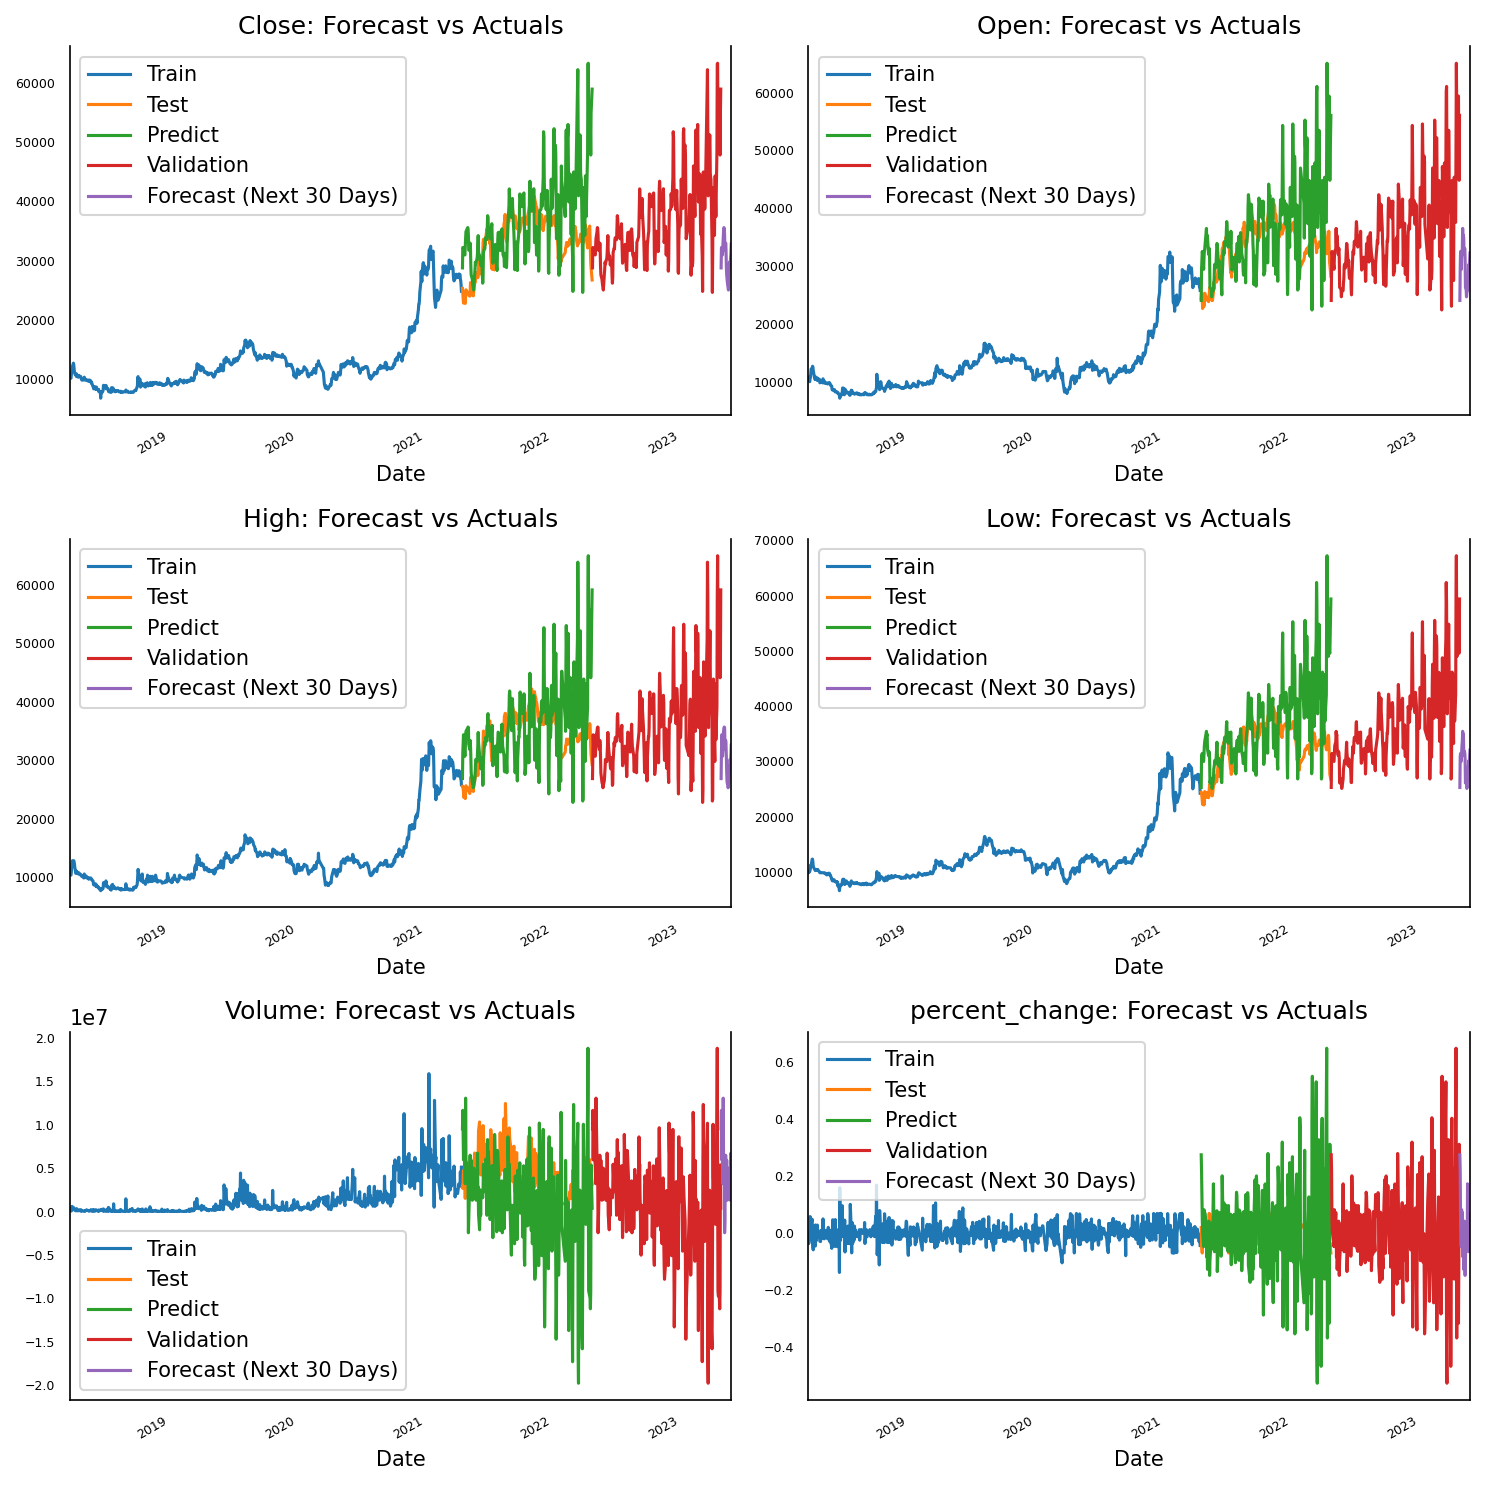

In [283]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
